In [1]:
import torch
import numpy as np
from mllib.src.train import main

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch.cuda
from src.evaluate import evaluate
from src.utils import prepare_device, load_yaml

/home/daniel0413/.conda/envs/torch_171_daniel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/daniel0413/.conda/envs/torch_171_daniel/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
config = "./result/mel-rnn/20230202-145405/config.yaml"
solver = main(path_config=config, return_solver=True)

------------------------------
	Search training datasets...
ROOT:  ./mllib/data/VoiceBankDEMAND/DS_10283_2791/noisy_trainset_28spk_wav
Folder:  []
Files:  ['p244_208.wav', 'p243_260.wav', 'p287_204.wav', 'p226_064.wav', 'p244_369.wav', 'p227_270.wav', 'p228_091.wav', 'p231_237.wav', 'p277_374.wav', 'p243_176.wav']

ROOT:  ./mllib/data/VoiceBankDEMAND/DS_10283_2791/noisy_trainset_56spk_wav
Folder:  []
Files:  ['p251_129.wav', 'p292_072.wav', 'p245_116.wav', 'p314_175.wav', 'p249_086.wav', 'p307_241.wav', 'p295_174.wav', 'p347_369.wav', 'p247_047.wav', 'p265_245.wav']

ROOT:  ./mllib/data/VoiceBankDEMAND/DS_10283_2791/clean_trainset_56spk_wav
Folder:  []
Files:  ['p251_129.wav', 'p292_072.wav', 'p245_116.wav', 'p314_175.wav', 'p249_086.wav', 'p307_241.wav', 'p295_174.wav', 'p347_369.wav', 'p247_047.wav', 'p265_245.wav']

ROOT:  ./mllib/data/VoiceBankDEMAND/DS_10283_2791/clean_trainset_28spk_wav
Folder:  []
Files:  ['p244_208.wav', 'p243_260.wav', 'p287_204.wav', 'p226_064.wav', 'p244_369

In [3]:
test_data = solver.test_dataloader
model = solver.model

In [4]:
args = load_yaml(config)
n_gpu = torch.cuda.device_count()
device = prepare_device(n_gpu, cudnn_deterministic=args.solver.cudnn_deterministic)

Using CuDNN deterministic mode in the experiment.


In [5]:
from mllib.src.distrib import get_train_wav_dataset
args.dset.wav = '/home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data'
train_dataset, validation_dataset, test_dataset = get_train_wav_dataset(config=args.dset, name="Clarity")

	 Original length: 22800
	 Offset: 0
	 Limit: None
	 Final length: 22800
	 Norm:  z-score
	 Sample rate:  16000
	 Offset: 0
	 Limit: None
	 Final length: 300
	 Norm:  z-score
	 Sample rate:  16000
Train 19380, Validation 3420, Test 300


In [6]:
# dataset = test_data.dataset
dataset = test_dataset
data = dataset[0]
mixture, clean, origial_length, name = data

In [7]:
nchannel, nsample = mixture.shape
if args.model.name in ("demucs", "conv-tasnet") and nchannel == 1:
    try:
        mixture = torch.cat(tensors=[mixture, mixture], dim=1)
        clean = torch.cat(tensors=[clean, clean], dim=1)
    except AttributeError:
        # For torch 1.7.1, AttributeError: module 'torch' has no attribute 'concat'
        mixture = torch.cat(tensors=[mixture, mixture], dim=1)
        clean = torch.cat(tensors=[clean, clean], dim=1)

if args.model.name not in ("demucs", "conv-tasnet"):
    mixture = torch.reshape(mixture, shape=(nchannel, 1, nsample))


In [8]:
mixture.shape

torch.Size([2, 1, 89594])

In [9]:
enhanced = evaluate(mixture=mixture, model=model, device=device, config=args)

/home/daniel0413/.conda/envs/torch_171_daniel/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/daniel0413/.conda/envs/torch_171_daniel/lib/python3.8/site-packages/torch/functional.py:586: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  return _VF.istft(input, n_fft, hop_length, win_length, window, center,  # type: ignore


In [10]:
assert enhanced.shape[-1] == mixture.shape[-1] == clean.shape[-1]

In [11]:
enhanced = enhanced.detach().cpu()

In [12]:
enhanced.shape, mixture.shape, clean.shape

(torch.Size([2, 1, 89594]), torch.Size([2, 1, 89594]), torch.Size([2, 89594]))

In [13]:
enhanced_np = enhanced.flatten().numpy()
mixture_np = mixture.flatten().numpy()
clean_np = clean.flatten().numpy()

In [14]:
enhanced_np = enhanced_np[:]
mixture_np = mixture_np[:]
clean_np = clean_np[:]

In [15]:
enhanced_np.shape, mixture_np.shape, clean_np.shape

((179188,), (179188,), (179188,))

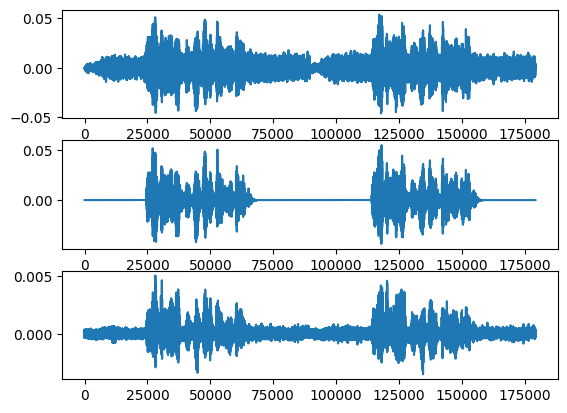

In [16]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3)

ax0.plot(mixture_np)
ax1.plot(clean_np)
ax2.plot(enhanced_np)


In [17]:
ipd.Audio(mixture_np, rate=args.dset.sample_rate)

In [18]:
ipd.Audio(clean_np, rate=args.dset.sample_rate)

In [19]:
ipd.Audio(enhanced_np, rate=args.dset.sample_rate)

## Weight distribution

In [33]:
parameters = [p.detach().cpu() for p in model.parameters()]

In [31]:
parameters[0]

array([[ 0.27926743,  0.13880812,  0.09068117, ..., -0.06132304,
        -0.02009919, -0.0247584 ],
       [ 0.27182034,  0.2268496 ,  0.20410644, ...,  0.03895214,
        -0.05245144,  0.01090455],
       [ 0.27613273,  0.09188823, -0.02635189, ...,  0.00115027,
        -0.02962787, -0.0363832 ],
       ...,
       [ 0.00111288,  0.00170295, -0.00073173, ..., -0.04547417,
        -0.05816139,  0.0127144 ],
       [-0.00544694,  0.01498102, -0.01628066, ...,  0.01770998,
         0.04809804, -0.03544647],
       [ 0.00114288,  0.00043267,  0.00618911, ...,  0.02701424,
        -0.05197084, -0.06419277]], dtype=float32)